# STOPS IN THE TRAJECTORY

This Notebook contains a study of the stops performed in the experiment. We detect the stops and their duration in the data-set and display them on maps.

**1. Individual stops**. For a SINGLE trajectory, we return the number of the stops, the duration of the stops and their location (latitude, longitude). We print the individual stop statistics (mean duration, etc.) and we also display location of the stops on a map together with their duration in seconds.

**2. All trajectories stops**. We use the function above (1) to study the stops of all the trajectories (iterating over all csv files). Then we store ALL the stops durations and locations in lists in order to print averaged statistics and plot ALL the stops on the map.

In [14]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from shapely.geometry import Point, LineString, Polygon   # For geometries
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from numpy.random import shuffle
from math import sin, cos, sqrt, atan2, radians
import networkx as nx   # Operations with networks
import osmnx as ox  # OpenStreetMaps to obtain urban street networks and  map visualisation


def map_network(lon1,lat1,lon2,lat2,lon3,lat3,lon4,lat4):
    """" Function that creates a map of the urban network from a polygon (given the 4 bounds).
    
    NOTE THAT THE GPS COORDS. MUST BE PROVIDED BY FIRST INDICATING THE LONGITUDE AND THEN THE LATITUDE (AS OPPOSED TO THE
    COORDINATES GIVEN GY GOOGLEMAPS WHEN SELECTING A PLACE, FOR EXAMPLE.)
    
    Input:
        - bounds: 4 latitude and longitude points (GPS coordinates). From GoogleMaps for example
        
    Output:
        - The figure and the axes.
        
    """
    
    P = Polygon([(lon1,lat1), (lon2,lat2),(lon3,lat3),(lon4,lat4)])  # Create the graph from lat and lon bounds
    G = ox.graph_from_polygon(P, network_type='all') 
    
    # Create the figure from the graph. The graph is composed by the edges (streets) and the nodes (street intersections).
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="#333333",edge_color="w", edge_linewidth=0.7, node_size=0)
    
    # We can import and plot the buildings using "tags" (also with parks, pedestrian highways, etc.)
    place_name = "Granollers, Vallès Oriental"
    place_name2 = 'Les Corts, Barcelona'
    
    tags={"building": True}
    tags_parks={"leisure": "park"}
    gdf = ox.geometries_from_place(place_name, tags)
    gdf_parks = ox.geometries_from_place(place_name, tags_parks)
    
    gdf.plot(ax=ax,color='silver',alpha=0.5) # plot buildings
    gdf_parks.plot(ax=ax,color='darkgreen',alpha=0.2) # plot parks
    buildings = ox.geometries_from_place(place_name, tags={'building':True}) # Retrieve buildings from the area.
    
    return fig, ax

# 1. Individual stops

In [28]:
def individual_stops(df):
    """ This function prints the statistics of the stops of the trajectory (number of stops, mean duration, etc.) and plot
        all the stops on a map (together with the duration).
        
        Inputs:
            - Data-frame with the data of the trajectory (stops, longitude, latitude, etc.)
            
        Outputs:
            - Number of the stops of the trajectory
            - List with the durations of the stops
            - List with the latitudes of the stops
            - List with the longitudes of the stops
            - It also prints the statistics of the stops and the stops map.
    
    """
    
    # Number of stops and duration of stops. Using the tags "stop" or "moving" for each GPS record, we can study the number of
    # stops of an individual trip and the duration of these. We consider as a single stop if there are two or more consecutive 
    # stops (i.e., two or more consecutive records labelled as "stop"). Then we sum their corresponding durations.
    
    t=df['At'].tolist()  # increment times to list
    stops=df['stops'].tolist()  # column stops to list
    lat=df['lat'].tolist()
    lon=df['lon'].tolist()
    
    At_cs=[]  # durations of the stops
    lon_stop=[] # longitudes of the stops
    lat_stop=[] # latitudes of the stops
    i=0
    while i < len(stops)-1:
        if stops[i]=='moving':       # We store the duration of the stops. If there are two or more consecutive stops, we sum
            i=i+1                    # their corresponding durations and we consider them as a single stop.
        else:
            s=0
            stopss=[]
            while stops[i+s]=='stop':
                stopss.append(t[i+s])
                s=s+1

            At_c=sum(stopss)
            At_cs.append(At_c)
            
            lat_stop.append(lat[i])
            lon_stop.append(lon[i])
            
            i=i+s
    
    number_stops = len(At_cs)
    print('The number of stops in the trajectory is {}'.format(number_stops))
    print('The total duration of the stops is {} s'.format(sum(At_cs)))
    print('The shortest stop is {} s'.format(min(At_cs)))
    print('The longest stop is {} s'.format(max(At_cs)))
    
    if len(At_cs)!=0:
        mean_stop_time = sum(At_cs)/len(At_cs)
        std_stop_time = np.std(At_cs)
        error_mean_stop_time = std_stop_time / np.sqrt(len(At_cs))
        print('The average stop duration is <T_stop> = {:.2f} \u00B1 {:.2f} s'.format(mean_stop_time,error_mean_stop_time)) 
        print('The standard deviation of the stop duration is \u03C3(stop) = {:.2f} s'.format(std_stop_time))     

    else:
        print('There are NO stops in the trajectory')
        mean_stop_time=0.0
    print('')
    
    
    
    # PLOT THE STOPS ON A MAP

    
    # Barri Primer de Maig (Granollers)
    lat1_granollers=41.605107921345585
    lon1_granollers=2.2804419490443517
    
    lat2_granollers=41.60183248235341
    lon2_granollers=2.28054397694062

    lat3_granollers=41.602065783859004
    lon3_granollers=2.283748215236327

    lat4_granollers=41.60530532450823
    lon4_granollers=2.2840062702794897
    
    
    
    # Palau Reial
    lat1_palau_reial=41.39051274619827
    lon1_palau_reial=2.120995295130168

    lat2_palau_reial=41.3848189661481
    lon2_palau_reial=2.1218877896916606

    lat3_palau_reial=41.3833175990405
    lon3_palau_reial=2.114868544114087

    lat4_palau_reial=41.38867332570979
    lon4_palau_reial=2.113224800622489


    fig, ax = map_network(lon1_granollers, lat1_granollers, lon2_granollers, lat2_granollers, 
                          lon3_granollers, lat3_granollers, lon4_granollers, lat4_granollers)  # Generate the map

    #fig, ax = map_network(lon1_palau_reial, lat1_palau_reial, lon2_palau_reial, lat2_palau_reial, 
                          #lon3_palau_reial, lat3_palau_reial, lon4_palau_reial, lat4_palau_reial)  # Generate the map

    
    # For plotting purposes, we rescale the list of stops duration (dividing by the maximum value) and multiply each value by
    # 200 (otherwise it looks to small on the map)
    max_At=max(At_cs)
    new_At_cs=[]
    for j in range(len(At_cs)):
        new_At_cs.append(200*(At_cs[j]/max_At))
    

    plt.scatter(lon_stop,lat_stop,c='yellow',s=new_At_cs)
    
    
    bbox_args = dict(boxstyle='square',facecolor='white', edgecolor='k',alpha=0.8)
    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='white')
    for i in range(len(lon_stop)):
        plt.annotate(str(int(At_cs[i]))+ 's', (lon_stop[i], lat_stop[i]),c='seagreen',size=10,
                     bbox=bbox_args,arrowprops=arrowprops, xytext=(-20, 18),textcoords='offset points')

    plt.show()
    
    
    return number_stops, At_cs, lon_stop, lat_stop



    

The number of stops in the trajectory is 18
The total duration of the stops is 2208.0 s
The shortest stop is 11.0 s
The longest stop is 836.0 s
The average stop duration is <T_stop> = 122.67 ± 48.96 s
The standard deviation of the stop duration is σ(stop) = 207.71 s



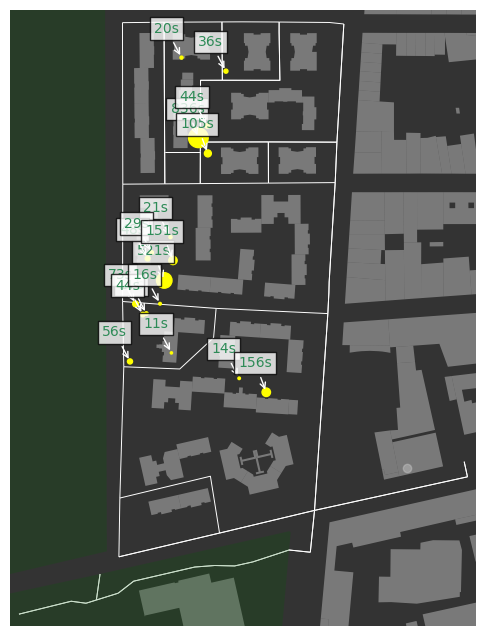

In [29]:
df = pd.read_csv('processed data\\e1.csv')
n_stops, stops_duration, lon_stops, lat_stops = individual_stops(df)

# 2. All trajectories stops

In [34]:
def all_trajectories_stops():
    """ This function prints the individual statistics of the stops of the trajectory (number of stops, mean duration, etc.) and plot
    all the stops on a map (together with the duration), using the function above for individual trajectories.
    
    Then, it prints the averaged statistics of ALL stops (from all trajectories) and displays all the stops on the map.

    Inputs:
        - None. Though is necessary to have all trajectories in .csv format in the same folder (and with no extra csv files)

    Outputs:
        - Stop statistics of each individual trajectory
        - Averaged stop statistics (over all trajectories)
        - Map visualisation of the stops and their duration
    
    """
    all_files = glob.glob(os.path.join("processed data\\*.csv")) # Make list of paths (csv files for all individual trajectories)    
    
    n_stops_all=[]
    stops_duration_all=[]
    lon_stops=[]
    lat_stops=[]
    for file in all_files:   # Loop over all .csv files 
        df = pd.read_csv(file) # read csv file to data-frame    
        
        # PRINT THE INDIVIDUAL STATISTICS (OF EACH TRAJECTORY)
        print('*******************************')
        print('TRAJECTORY {}'.format(file))
        print('*******************************')
        print('')
        
        n_stops, stops_duration, lon_stop, lat_stop = individual_stops(df)
        print('')
        n_stops_all.append(n_stops)
        stops_duration_all.extend(stops_duration)
        lon_stops.extend(lon_stop)
        lat_stops.extend(lat_stop)
    
    print('----------------------------------------------------------------')
    print('')
    print('AVERAGED STATISTICS')
    print('')
    
    # AVERAGED STATISTICS OF ALL STOPS
    mean_number_stops_all = np.mean(n_stops_all)
    std_number_stops_all = np.std(n_stops_all)
    error_mean_number_stops_all = std_number_stops_all / np.sqrt(len(n_stops_all))
    q1_number_stops_all = np.quantile(n_stops_all,0.25)
    q2_number_stops_all = np.quantile(n_stops_all,0.5)
    q3_number_stops_all= np.quantile(n_stops_all,0.75)
    min_number_stops_all = min(n_stops_all)
    max_number_stops_all = max(n_stops_all)
    print('The average number of stops of each group is {:.2f} \u00B1 {:.2f}  ---> \u03C3(stops) = {:.2f}'.format(mean_number_stops_all,
                                                                                                       error_mean_number_stops_all,
                                                                                                      std_number_stops_all))
    print('The group with less stops has {:.2f} stops and the group with more has {:.2f} stops'.format(min_number_stops_all,
                                                                                                       max_number_stops_all))
    print('The quantiles are:')
    print('Q1(25%) = {:.2f},  Q2(50%) = {:.2f},  Q3(75%) = {:.2f}'.format(q1_number_stops_all,q2_number_stops_all,q3_number_stops_all))
    print('')
    
    mean_duration_stops_all = np.mean(stops_duration_all)
    std_duration_stops_all = np.std(stops_duration_all)
    error_mean_duration_stops_all = std_duration_stops_all / np.sqrt(len(stops_duration_all))
    q1_duration_stops_all = np.quantile(stops_duration_all,0.25)
    q2_duration_stops_all = np.quantile(stops_duration_all,0.5)
    q3_duration_stops_all= np.quantile(stops_duration_all,0.75)
    min_duration_stops_all = min(stops_duration_all)
    max_duration_stops_all = max(stops_duration_all)
    print('The average duration of all stops is {:.2f} \u00B1 {:.2f}s  ---> \u03C3(T_stops) = {:.2f}s'.format(mean_duration_stops_all,
                                                                                                       error_mean_duration_stops_all,
                                                                                                      std_duration_stops_all))
    print('The shortest stop is {:.2f}s and the longest {:.2f}s'.format(min_duration_stops_all,max_duration_stops_all))
    print('The quantiles are:')
    print('Q1(25%) = {:.2f}s,  Q2(50%) = {:.2f}s,  Q3(75%) = {:.2f}s'.format(q1_duration_stops_all,q2_duration_stops_all,q3_duration_stops_all))
    print('') 
    
    
    
    # PLOT THE STOPS ON A MAP

    # Barri Primer de Maig (Granollers)
    lat1_granollers=41.605107921345585
    lon1_granollers=2.2804419490443517
    
    lat2_granollers=41.60183248235341
    lon2_granollers=2.28054397694062

    lat3_granollers=41.602065783859004
    lon3_granollers=2.283748215236327

    lat4_granollers=41.60530532450823
    lon4_granollers=2.2840062702794897
    
    
    # Palau Reial
    lat1_palau_reial=41.39051274619827
    lon1_palau_reial=2.120995295130168

    lat2_palau_reial=41.3848189661481
    lon2_palau_reial=2.1218877896916606

    lat3_palau_reial=41.3833175990405
    lon3_palau_reial=2.114868544114087

    lat4_palau_reial=41.38867332570979
    lon4_palau_reial=2.113224800622489
    
    
    fig, ax = map_network(lon1_granollers, lat1_granollers, lon2_granollers, lat2_granollers, 
                          lon3_granollers, lat3_granollers, lon4_granollers, lat4_granollers)  # Generate the map

    #fig, ax = map_network(lon1_palau_reial, lat1_palau_reial, lon2_palau_reial, lat2_palau_reial, 
                          #lon3_palau_reial, lat3_palau_reial, lon4_palau_reial, lat4_palau_reial)  # Generate the map

    
    # For plotting purposes, we rescale the list of stops duration (dividing by the maximum value) and multiply each value by
    # 200 (otherwise it looks to small on the map)
    max_At=max(stops_duration_all)
    new_At_cs=[]
    for j in range(len(stops_duration_all)):
        new_At_cs.append(200*(stops_duration_all[j]/max_At))
    

    plt.scatter(lon_stops,lat_stops,c='yellow',s=new_At_cs)
    
    
    bbox_args = dict(boxstyle='square',facecolor='white', edgecolor='k',alpha=0.8)
    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0',color='white')
    for i in range(len(lon_stops)):
        plt.annotate(str(int(stops_duration_all[i]))+ 's', (lon_stops[i], lat_stops[i]),c='seagreen',size=10,
                     bbox=bbox_args,arrowprops=arrowprops, xytext=(-20, 18),textcoords='offset points')

    plt.show()
    
    

*******************************
TRAJECTORY processed data\e1.csv
*******************************

The number of stops in the trajectory is 18
The total duration of the stops is 2208.0 s
The shortest stop is 11.0 s
The longest stop is 836.0 s
The average stop duration is <T_stop> = 122.67 ± 48.96 s
The standard deviation of the stop duration is σ(stop) = 207.71 s



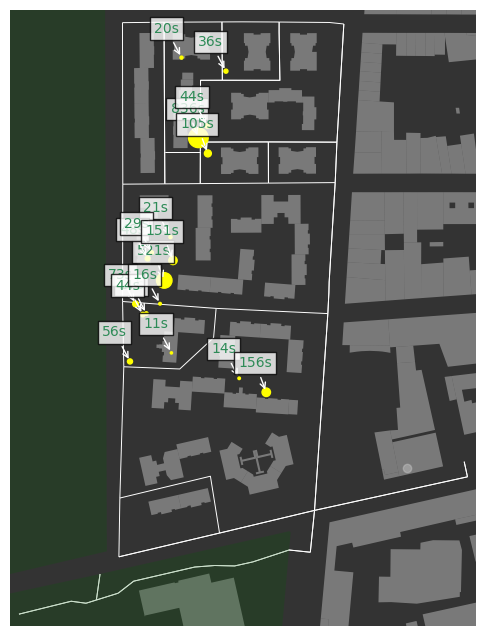


*******************************
TRAJECTORY processed data\e2.csv
*******************************

The number of stops in the trajectory is 17
The total duration of the stops is 3647.0 s
The shortest stop is 10.0 s
The longest stop is 1593.0 s
The average stop duration is <T_stop> = 214.53 ± 93.54 s
The standard deviation of the stop duration is σ(stop) = 385.69 s



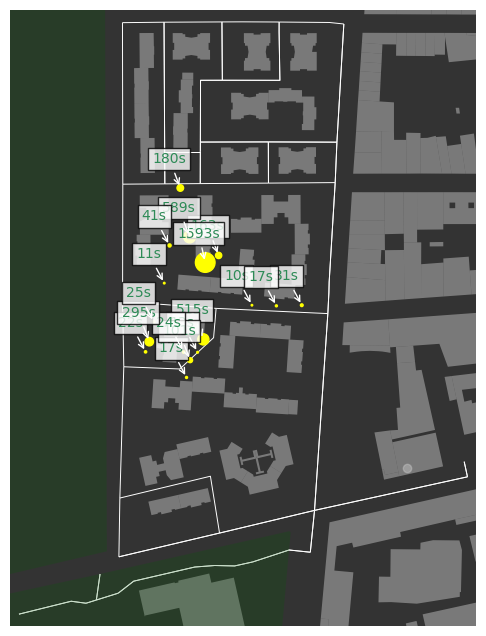


*******************************
TRAJECTORY processed data\e3.csv
*******************************

The number of stops in the trajectory is 16
The total duration of the stops is 3599.0 s
The shortest stop is 10.0 s
The longest stop is 1130.0 s
The average stop duration is <T_stop> = 224.94 ± 81.82 s
The standard deviation of the stop duration is σ(stop) = 327.29 s



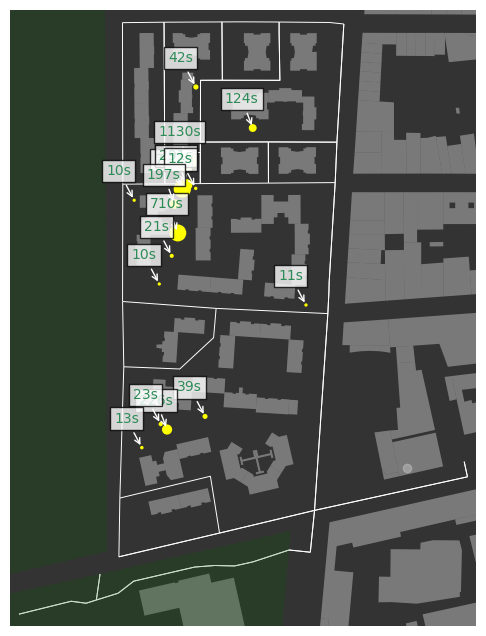


*******************************
TRAJECTORY processed data\e4.csv
*******************************

The number of stops in the trajectory is 20
The total duration of the stops is 3295.0 s
The shortest stop is 10.0 s
The longest stop is 601.0 s
The average stop duration is <T_stop> = 164.75 ± 44.47 s
The standard deviation of the stop duration is σ(stop) = 198.90 s



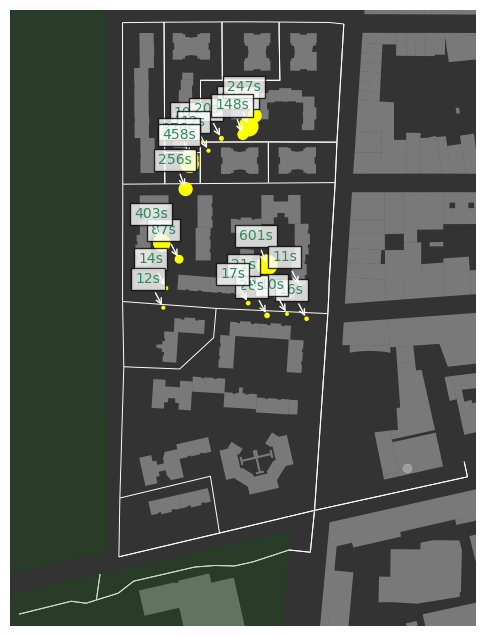


*******************************
TRAJECTORY processed data\e5.csv
*******************************

The number of stops in the trajectory is 29
The total duration of the stops is 3249.0 s
The shortest stop is 10.0 s
The longest stop is 806.0 s
The average stop duration is <T_stop> = 112.03 ± 33.64 s
The standard deviation of the stop duration is σ(stop) = 181.18 s



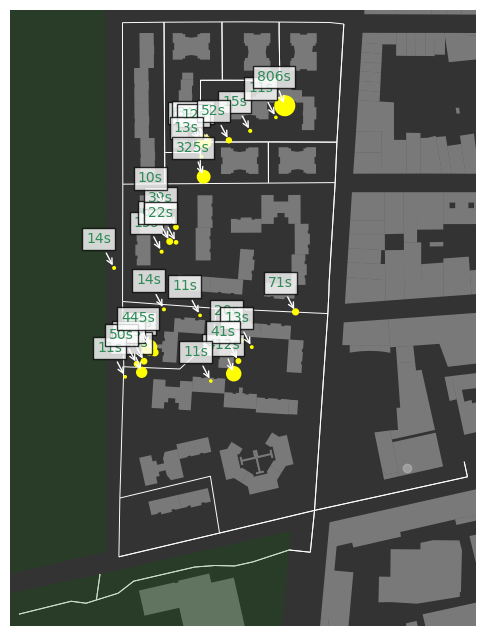


*******************************
TRAJECTORY processed data\e6.csv
*******************************

The number of stops in the trajectory is 21
The total duration of the stops is 3003.0 s
The shortest stop is 10.0 s
The longest stop is 681.0 s
The average stop duration is <T_stop> = 143.00 ± 44.67 s
The standard deviation of the stop duration is σ(stop) = 204.69 s



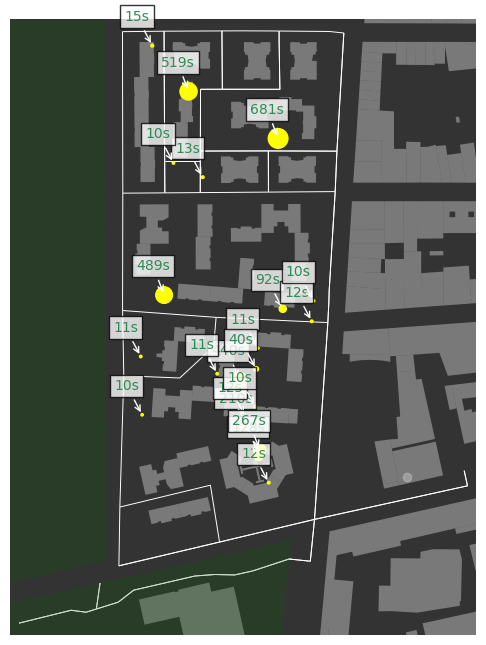


*******************************
TRAJECTORY processed data\e7.csv
*******************************

The number of stops in the trajectory is 32
The total duration of the stops is 3178.0 s
The shortest stop is 10.0 s
The longest stop is 1006.0 s
The average stop duration is <T_stop> = 99.31 ± 35.62 s
The standard deviation of the stop duration is σ(stop) = 201.52 s



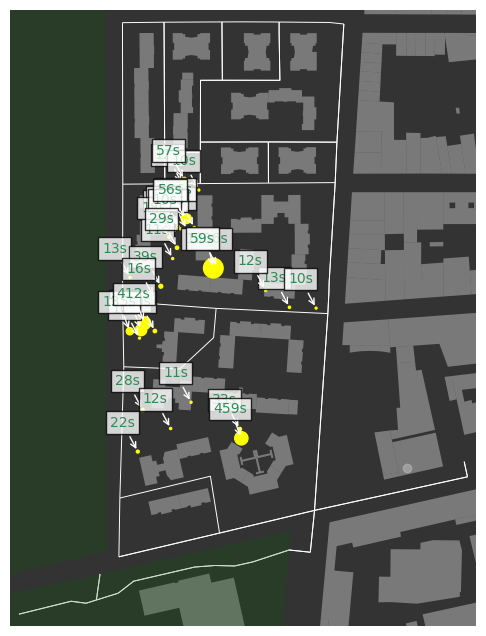


*******************************
TRAJECTORY processed data\g1.csv
*******************************

The number of stops in the trajectory is 36
The total duration of the stops is 6571.0 s
The shortest stop is 10.0 s
The longest stop is 1805.0 s
The average stop duration is <T_stop> = 182.53 ± 62.61 s
The standard deviation of the stop duration is σ(stop) = 375.67 s



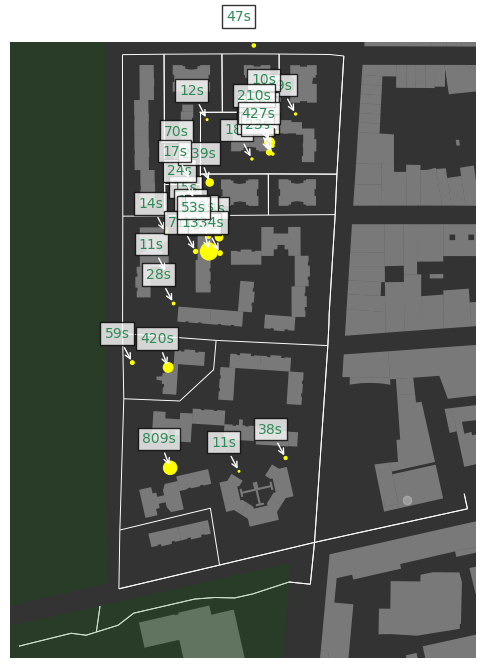


*******************************
TRAJECTORY processed data\g2.csv
*******************************

The number of stops in the trajectory is 4
The total duration of the stops is 471.0 s
The shortest stop is 14.0 s
The longest stop is 427.0 s
The average stop duration is <T_stop> = 117.75 ± 89.27 s
The standard deviation of the stop duration is σ(stop) = 178.55 s



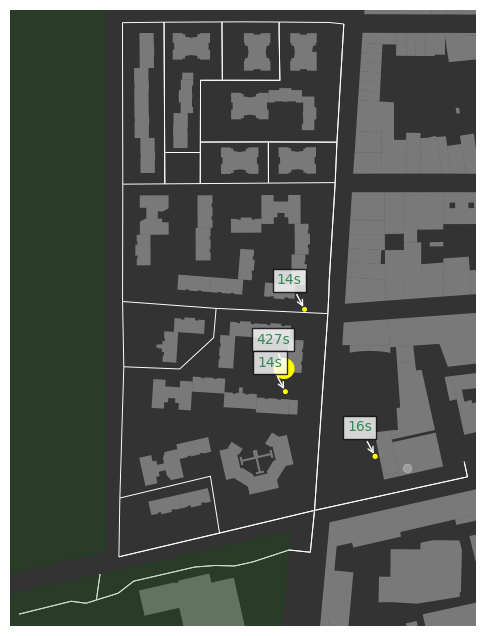


*******************************
TRAJECTORY processed data\g3.csv
*******************************

The number of stops in the trajectory is 21
The total duration of the stops is 5458.0 s
The shortest stop is 10.0 s
The longest stop is 2669.0 s
The average stop duration is <T_stop> = 259.90 ± 137.84 s
The standard deviation of the stop duration is σ(stop) = 631.66 s



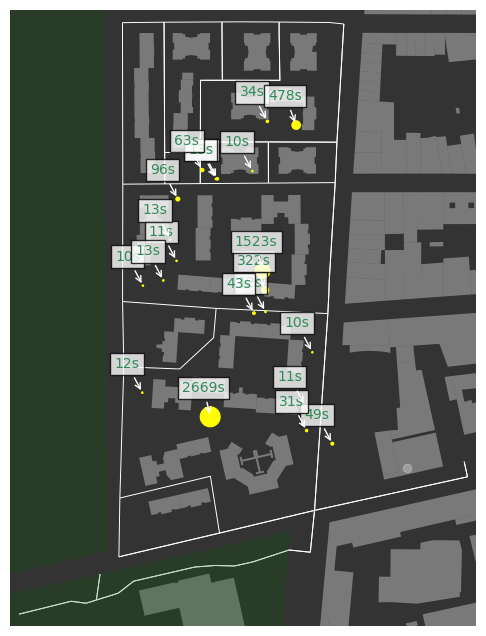


*******************************
TRAJECTORY processed data\g4.csv
*******************************

The number of stops in the trajectory is 5
The total duration of the stops is 1932.0 s
The shortest stop is 30.0 s
The longest stop is 1243.0 s
The average stop duration is <T_stop> = 386.40 ± 202.51 s
The standard deviation of the stop duration is σ(stop) = 452.82 s



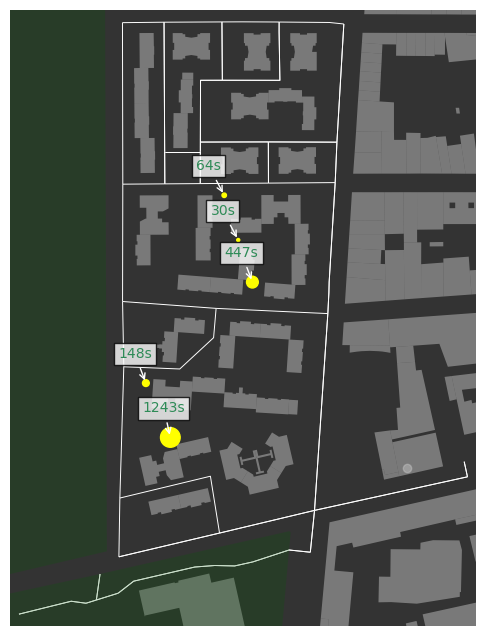


*******************************
TRAJECTORY processed data\g5.csv
*******************************

The number of stops in the trajectory is 20
The total duration of the stops is 4206.0 s
The shortest stop is 10.0 s
The longest stop is 1223.0 s
The average stop duration is <T_stop> = 210.30 ± 78.72 s
The standard deviation of the stop duration is σ(stop) = 352.05 s



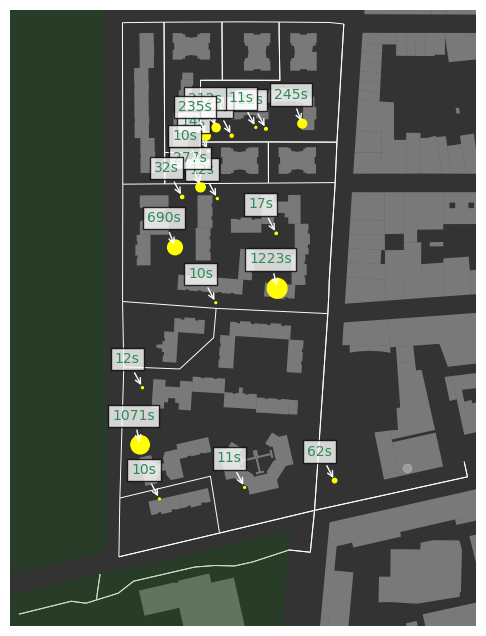


*******************************
TRAJECTORY processed data\g6.csv
*******************************

The number of stops in the trajectory is 13
The total duration of the stops is 4884.0 s
The shortest stop is 11.0 s
The longest stop is 2467.0 s
The average stop duration is <T_stop> = 375.69 ± 183.74 s
The standard deviation of the stop duration is σ(stop) = 662.50 s



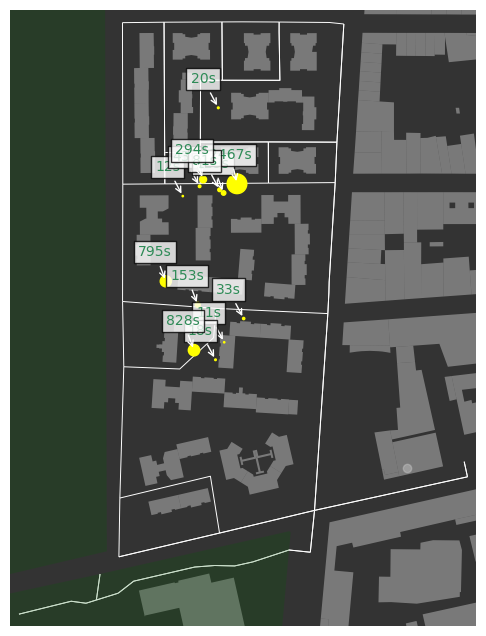


*******************************
TRAJECTORY processed data\g7.csv
*******************************

The number of stops in the trajectory is 22
The total duration of the stops is 5213.0 s
The shortest stop is 10.0 s
The longest stop is 1955.0 s
The average stop duration is <T_stop> = 236.95 ± 90.38 s
The standard deviation of the stop duration is σ(stop) = 423.93 s



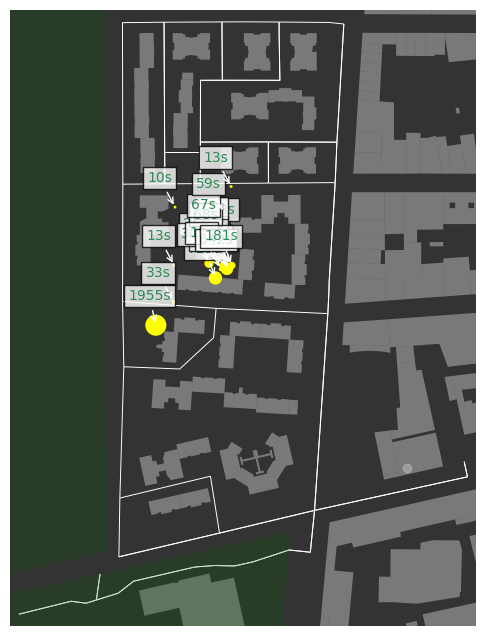


*******************************
TRAJECTORY processed data\g8.csv
*******************************

The number of stops in the trajectory is 15
The total duration of the stops is 2554.0 s
The shortest stop is 10.0 s
The longest stop is 918.0 s
The average stop duration is <T_stop> = 170.27 ± 68.68 s
The standard deviation of the stop duration is σ(stop) = 265.98 s



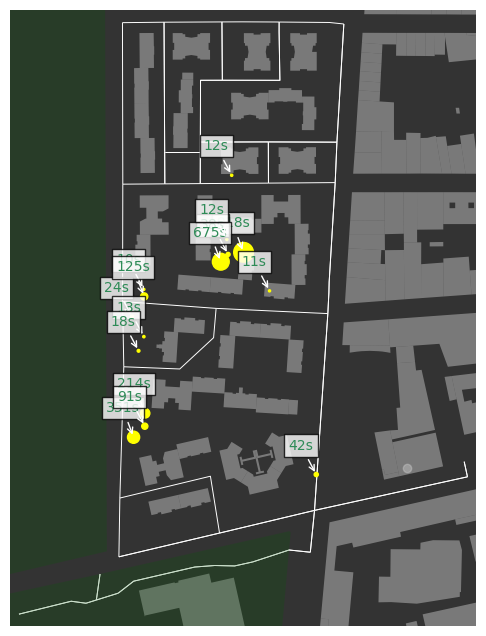


*******************************
TRAJECTORY processed data\p1.csv
*******************************

The number of stops in the trajectory is 16
The total duration of the stops is 4712.0 s
The shortest stop is 10.0 s
The longest stop is 1887.0 s
The average stop duration is <T_stop> = 294.50 ± 123.19 s
The standard deviation of the stop duration is σ(stop) = 492.76 s



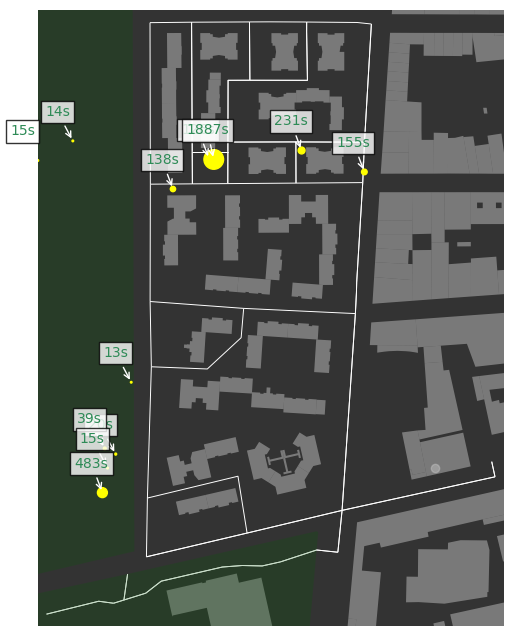


*******************************
TRAJECTORY processed data\p2.csv
*******************************

The number of stops in the trajectory is 17
The total duration of the stops is 3051.0 s
The shortest stop is 10.0 s
The longest stop is 1199.0 s
The average stop duration is <T_stop> = 179.47 ± 68.67 s
The standard deviation of the stop duration is σ(stop) = 283.12 s



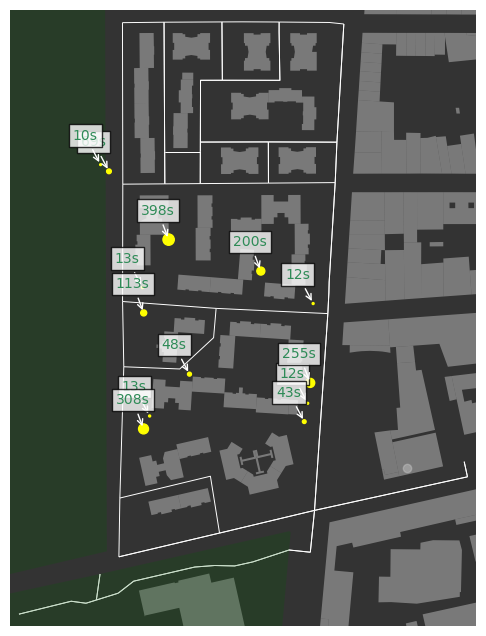


*******************************
TRAJECTORY processed data\p4.csv
*******************************

The number of stops in the trajectory is 17
The total duration of the stops is 3375.0 s
The shortest stop is 11.0 s
The longest stop is 1811.0 s
The average stop duration is <T_stop> = 198.53 ± 100.41 s
The standard deviation of the stop duration is σ(stop) = 414.01 s



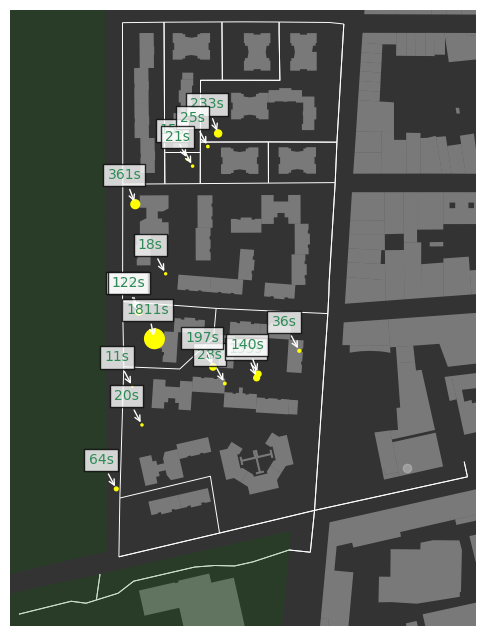


----------------------------------------------------------------

AVERAGED STATISTICS

The average number of stops of each group is 18.83 ± 1.83  ---> σ(stops) = 7.75
The group with less stops has 4.00 stops and the group with more has 36.00 stops
The quantiles are:
Q1(25%) = 16.00,  Q2(50%) = 17.50,  Q3(75%) = 21.00

The average duration of all stops is 190.58 ± 20.12s  ---> σ(T_stops) = 370.49s
The shortest stop is 10.00s and the longest 2669.00s
The quantiles are:
Q1(25%) = 13.00s,  Q2(50%) = 36.00s,  Q3(75%) = 198.50s



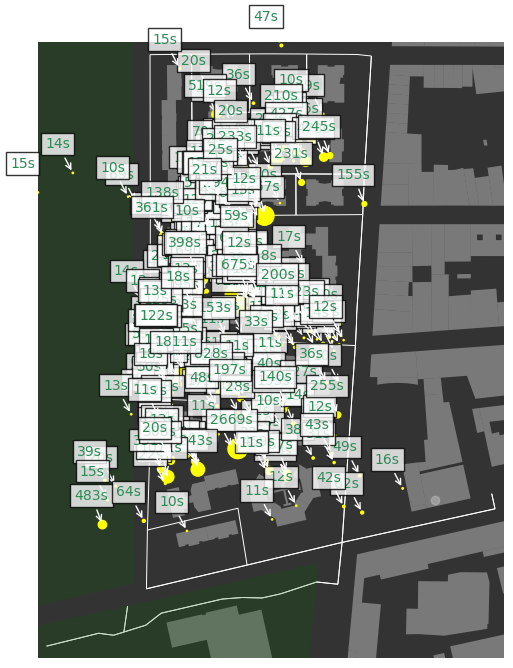

In [35]:
all_trajectories_stops()